In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
sns.set()

В рассматриваемом наборе данных нужно определить класс качества вина (quality) в зависимости от его параметров:
     - fixed acidity (фиксированная кислотность);
     - volatile acidity (летучая кислотность);
     - citric acid (лимонная кислота);
     - residual sugar (остаточный сахар);
     - chlorides (хлориды);
     - free sulfur dioxide (свободный диоксид серы);
     - total sulfur dioxide (общий диоксид серы);
     - density (плотность);
     - pH;
     - sulphates (сульфаты);
     - alcohol (градусы).
 Так как целевой признак quality является порядковым категориальным, то предстоит решить задачу классификации. 

In [2]:
SMALL_SIZE = 12
SIZE = 15
BIG_SIZE = 20

In [3]:
data = pd.read_csv('winequality-white.csv', sep=';') # считываем данные в датафрейм из csv файла 

In [4]:
data.head() # просмотр начала датафрейма

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
data.shape # размер датафрейма (количество строк и столбцов)

(4898, 12)

In [51]:
data.dtypes # тип данных в столбцах (везде, кроме целевого признака, вещественный)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [52]:
data.isna().sum() # проверка на наличие пропусков (отсутствуют)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [53]:
data.drop('quality', axis=1).describe() # вычисление сводных показателей для количественных признаков

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


In [6]:
# определяем количество объектов каждого класса в целевом признаке
quality = data['quality'].value_counts().sort_index()
quality

3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64

In [55]:
# доля объектов каждого класса от общего количества объектов в целевом признаке
quality_rate = data['quality'].value_counts(normalize=True).sort_index()
np.round(quality_rate, 3)

3    0.004
4    0.033
5    0.297
6    0.449
7    0.180
8    0.036
9    0.001
Name: quality, dtype: float64

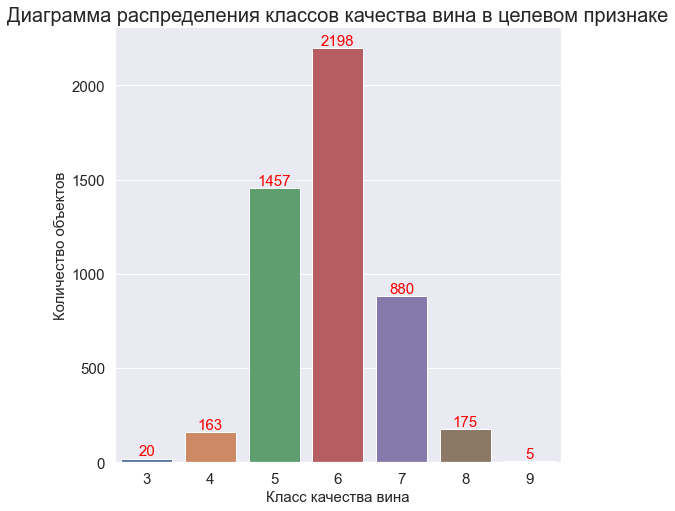

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=quality.index, y=quality.values)
ax.set_xlabel('Класс качества вина', fontsize=SIZE)
ax.set_ylabel('Количество объектов', fontsize=SIZE)
ax.set_title('Диаграмма распределения классов качества вина в целевом признаке', fontsize=BIG_SIZE)
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE)
counter = 0
style = dict(size=SIZE, color='red')
for ind in quality.index:
    ax.text(counter, quality[ind] + 15, str(quality[ind]), ha = 'center', **style)
    counter +=1

Из диаграммы распределения классов качества вина видно, что классы очень несбалансированы. Большая часть объектов принадлежит к классам среднего качества, в то время, как вин высокого и низкого качества сравнительно немного. 

In [9]:
# Ввиду малочисленности 9 и 3 классов, объединим их с 8 и 4 классами соответственно
data['quality'].replace([3, 9], [4, 8], inplace=True)
quality = data['quality'].value_counts().sort_index()
quality

4     183
5    1457
6    2198
7     880
8     180
Name: quality, dtype: int64

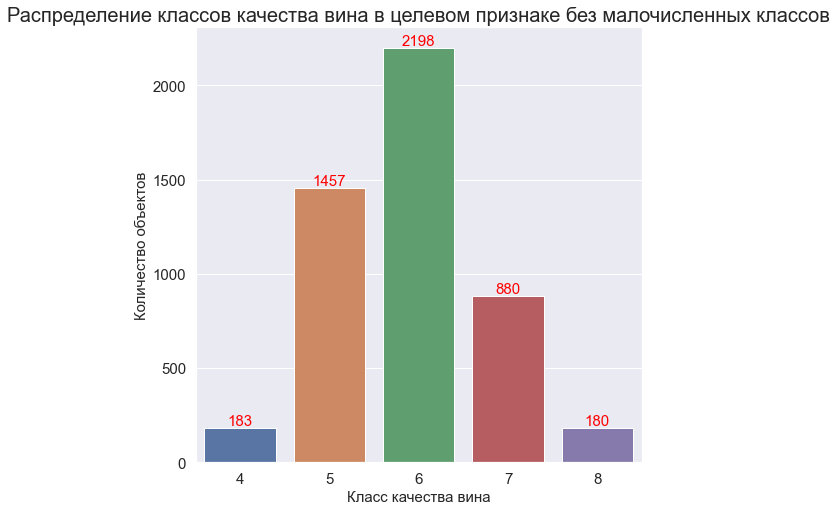

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=quality.index, y=quality.values)
ax.set_xlabel('Класс качества вина', fontsize=SIZE)
ax.set_ylabel('Количество объектов', fontsize=SIZE)
ax.set_title('Распределение классов качества вина в целевом признаке без малочисленных классов', fontsize=BIG_SIZE)
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE)
counter = 0
style = dict(size=SIZE, color='red')
for ind in quality.index:
    ax.text(counter, quality[ind] + 15, str(quality[ind]), ha = 'center', **style)
    counter +=1

Text(0.5, 1.0, 'Матрица корреляции')

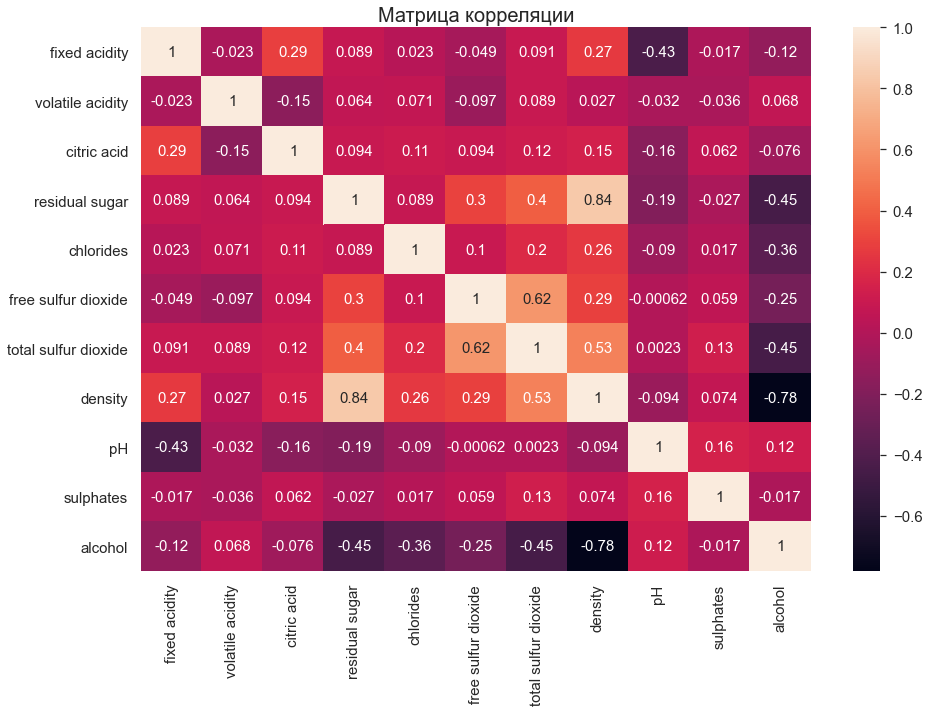

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, cbar=True) # построение матрицы корреляции признаков
plt.rc('font', size=SIZE)
ax.set_title('Матрица корреляции', fontsize=BIG_SIZE)

In [11]:
# Из корреляционной матрицы видно, что признак density в значительной степени коррелирует с признаками alcohol и residual sugar.
# Коэффициенты корреляции составляют -0.78 и 0.84 соответственно. Поэтому признак density удаляется из датафрейма.
data = data.drop('density', axis=1)

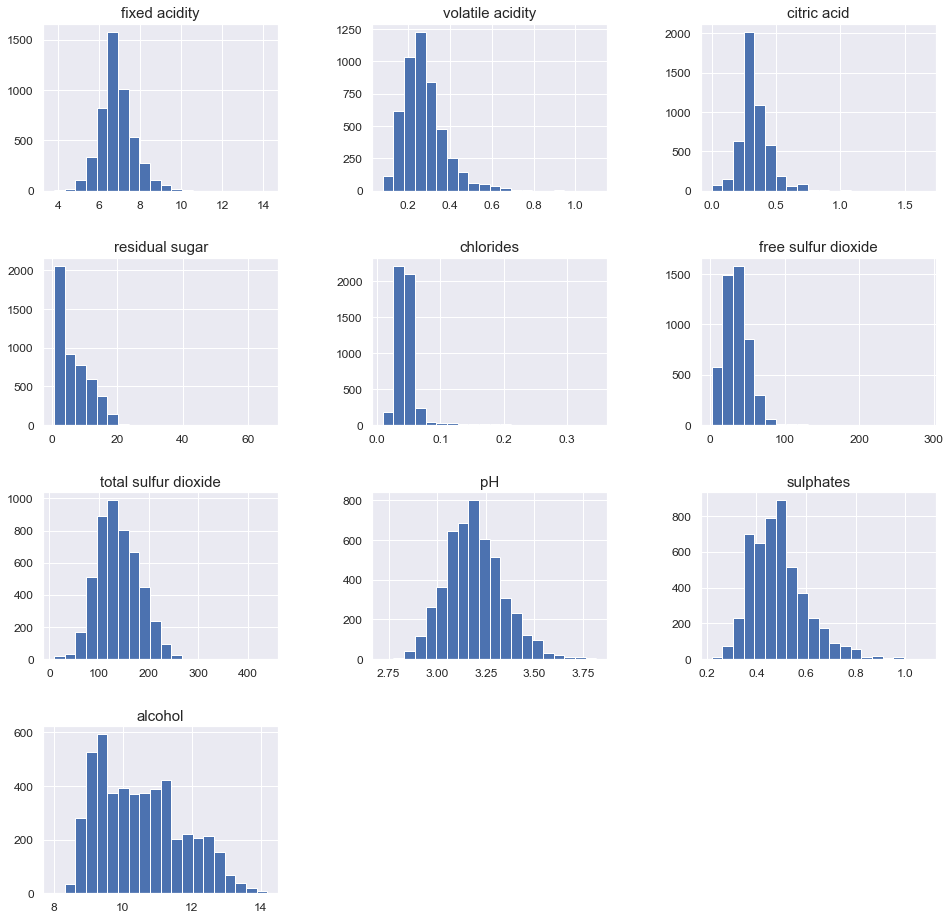

In [13]:
# построение гистограмм признаков
lst = list(data.iloc[:, :-1])
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(4, 3, i)
    ax.hist(data.iloc[:, i - 1], bins=20)
    ax.set_title(lst[i - 1], fontsize=SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)

Из гистограмм видно, что в признаках присутствуют выбросы.

Text(0.5, 0, 'Fixed acidity')

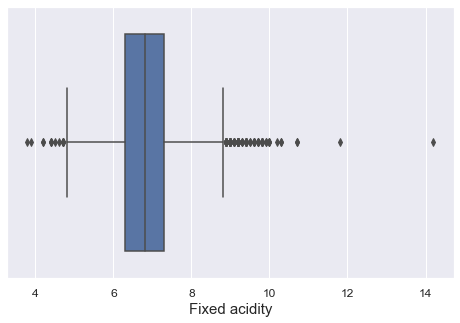

In [61]:
# Более подробно посмотреть на выбросы можно с помощью ящика с усами.
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['fixed acidity'])
ax.set_xlabel('Fixed acidity', fontsize=SIZE)

In [62]:
# Обнаруженные выбросы будем заменять на медианное значение признака
Q1, Q2, Q3 = np.quantile(data['fixed acidity'], [0.25, 0.5, 0.75]) # первый, второй и третий квартили
delta = Q3 - Q1 # межквартильный размах
mask = (data['fixed acidity'] > Q3 + 1.5 * delta) | (data['fixed acidity'] < Q1 - 1.5 * delta)
data.loc[mask, 'fixed acidity'] = Q2

Text(0.5, 0, 'Volatile acidity')

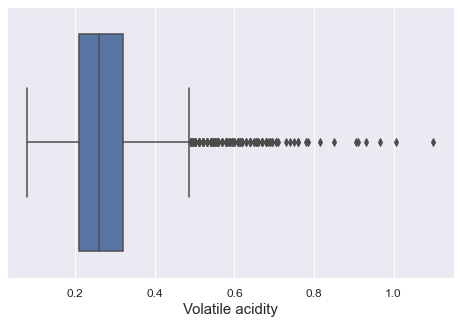

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['volatile acidity'])
ax.set_xlabel('Volatile acidity', fontsize=SIZE)

In [64]:
Q1, Q2, Q3 = np.quantile(data['volatile acidity'], [0.25, 0.5, 0.75])
delta = Q3 - Q1
mask = data['volatile acidity'] > Q3 + 1.5 * delta
data.loc[mask, 'volatile acidity'] = Q2

Text(0.5, 0, 'Citric acid')

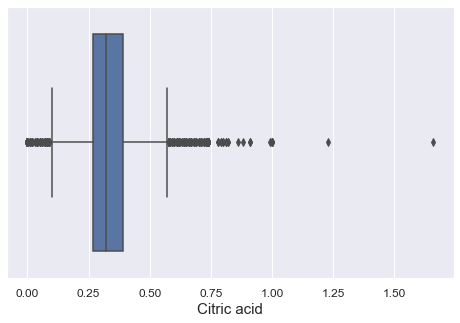

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['citric acid'])
ax.set_xlabel('Citric acid', fontsize=SIZE)

In [66]:
Q1, Q2, Q3 = np.quantile(data['citric acid'], [0.25, 0.5, 0.75])
delta = Q3 - Q1
mask = (data['citric acid'] > Q3 + 1.5 * delta) | (data['citric acid'] < Q1 - 1.5 * delta)
data.loc[mask, 'citric acid'] = Q2

Text(0.5, 0, 'Residual sugar')

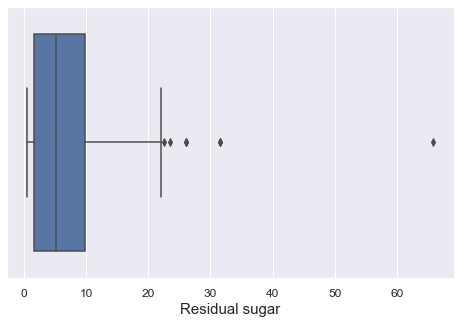

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['residual sugar'])
ax.set_xlabel('Residual sugar', fontsize=SIZE)

In [68]:
Q1, Q2, Q3 = np.quantile(data['residual sugar'], [0.25, 0.5, 0.75])
delta = Q3 - Q1
mask = data['residual sugar'] > Q3 + 1.5 * delta
data.loc[mask, 'residual sugar'] = Q2

Text(0.5, 0, 'Chlorides')

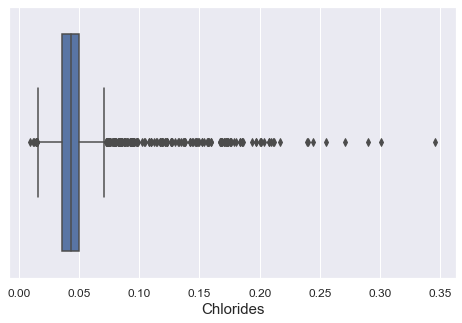

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['chlorides'])
ax.set_xlabel('Chlorides', fontsize=SIZE)

In [70]:
Q1, Q2, Q3 = np.quantile(data['chlorides'], [0.25, 0.5, 0.75])
delta = Q3 - Q1
mask = (data['chlorides'] > Q3 + 1.5 * delta) | (data['chlorides'] < Q1 - 1.5 * delta)
data.loc[mask, 'chlorides'] = Q2

Text(0.5, 0, 'Free sulfur dioxide')

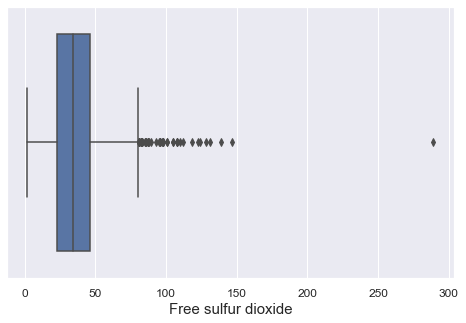

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['free sulfur dioxide'])
ax.set_xlabel('Free sulfur dioxide', fontsize=SIZE)

In [72]:
Q1, Q2, Q3 = np.quantile(data['free sulfur dioxide'], [0.25, 0.5, 0.75])
delta = Q3 - Q1
mask = data['free sulfur dioxide'] > Q3 + 1.5 * delta
data.loc[mask, 'free sulfur dioxide'] = Q2

Text(0.5, 0, 'Total sulfur dioxide')

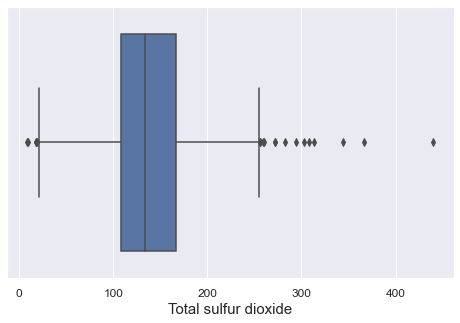

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['total sulfur dioxide'])
ax.set_xlabel('Total sulfur dioxide', fontsize=SIZE)

In [74]:
Q1, Q2, Q3 = np.quantile(data['total sulfur dioxide'], [0.25, 0.5, 0.75])
delta = Q3 - Q1
mask = (data['total sulfur dioxide'] > Q3 + 1.5 * delta) | (data['total sulfur dioxide'] < Q1 - 1.5 * delta)
data.loc[mask, 'total sulfur dioxide'] = Q2

Text(0.5, 0, 'pH')

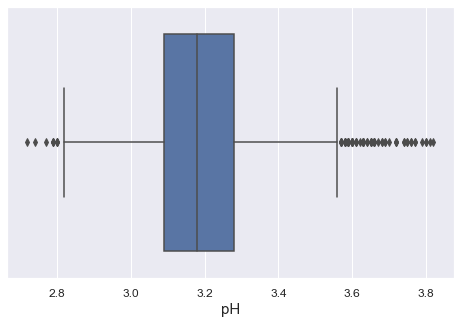

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['pH'])
ax.set_xlabel('pH', fontsize=SIZE)

In [76]:
Q1, Q2, Q3 = np.quantile(data['pH'], [0.25, 0.5, 0.75])
delta = Q3 - Q1
mask = (data['pH'] > Q3 + 1.5 * delta) | (data['pH'] < Q1 - 1.5 * delta)
data.loc[mask, 'pH'] = Q2

Text(0.5, 0, 'Sulphates')

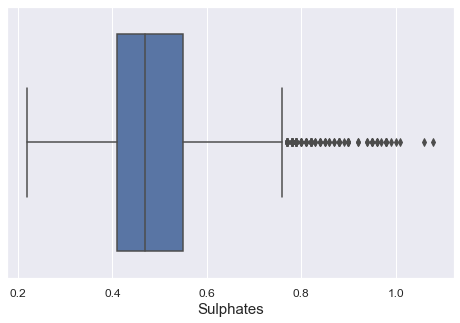

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['sulphates'])
ax.set_xlabel('Sulphates', fontsize=SIZE)

In [78]:
Q1, Q2, Q3 = np.quantile(data['sulphates'], [0.25, 0.5, 0.75])
delta = Q3 - Q1
mask = data['sulphates'] > Q3 + 1.5 * delta
data.loc[mask, 'sulphates'] = Q2

Text(0.5, 0, 'Alcohol')

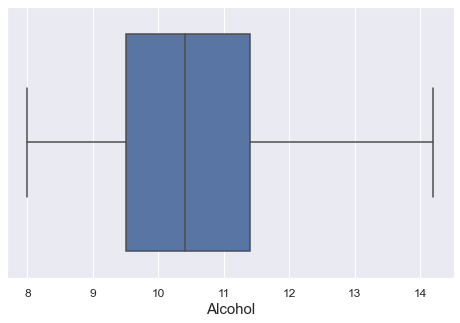

In [79]:
# В признаке alcohol выбросы не обнаружены
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['alcohol'])
ax.set_xlabel('Alcohol', fontsize=SIZE)

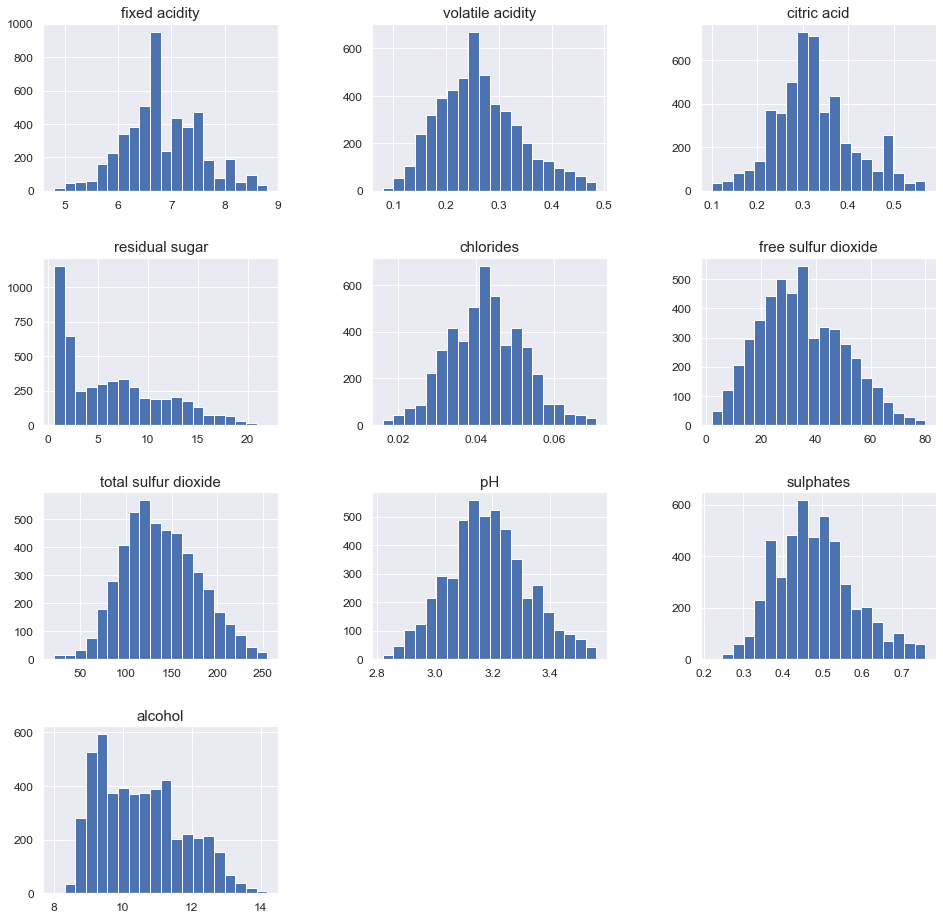

In [80]:
lst = list(data.iloc[:, :-1])
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(4, 3, i)
    ax.hist(data.iloc[:, i - 1], bins=20)
    ax.set_title(lst[i - 1], fontsize=SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)

Теперь из гистограмм признаков видно, что выбросы отсутствуют. 

In [81]:
# разбиение набора данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data.drop('quality', axis=1), 
                                                    data['quality'], test_size=0.2, random_state=1)

In [82]:
# создание классификатора на основе случайного леса с учётом несбалансированности классов без настройки параметров
clf = RandomForestClassifier(class_weight='balanced', random_state=1)
y_pred_train = clf.fit(X_train, y_train).predict(X_train) # предсказание на обучающей выборке
print(classification_report(y_train, y_pred_train, zero_division=0))

              precision    recall  f1-score   support

           4       1.00      1.00      1.00       152
           5       1.00      1.00      1.00      1164
           6       1.00      1.00      1.00      1763
           7       1.00      1.00      1.00       696
           8       1.00      1.00      1.00       143

    accuracy                           1.00      3918
   macro avg       1.00      1.00      1.00      3918
weighted avg       1.00      1.00      1.00      3918



Как видно из полученных метрик, на обучающей выборке классификтор с параметрами по умолчанию показывает идеальный результат, что свидетельствует о переобучении модели. Далее необходимо посмотреть на результат работы модели на тестовой выборке.

In [83]:
clf = RandomForestClassifier(class_weight='balanced', random_state=1)
y_pred_test = clf.fit(X_train, y_train).predict(X_test)  # предсказание на тестовой выборке
print(classification_report(y_test, y_pred_test, zero_division=0))

              precision    recall  f1-score   support

           4       0.57      0.13      0.21        31
           5       0.73      0.65      0.69       293
           6       0.64      0.82      0.71       435
           7       0.73      0.55      0.63       184
           8       0.87      0.35      0.50        37

    accuracy                           0.68       980
   macro avg       0.71      0.50      0.55       980
weighted avg       0.69      0.68      0.67       980



На тестовой выборке классификатор уже не показывает таких высоких значений метрик, особенно значительно снизилась полнота для
самого низкого 4 класса качества (0.13) и самого высокого 8 класса (0.35). Проблемы модели в идентификации объектов 4 и 8 классов подтверждают переобученность модели. Бесконтрольный рост деревьев решений, составляющих случайный лес, привёл к тому, что модель научилась идеально воспроизводить обучающую выборку, но плохо разобралась в сущности отличия объектов разных классов.

Text(50.760000000000005, 0.5, 'Истинный класс')

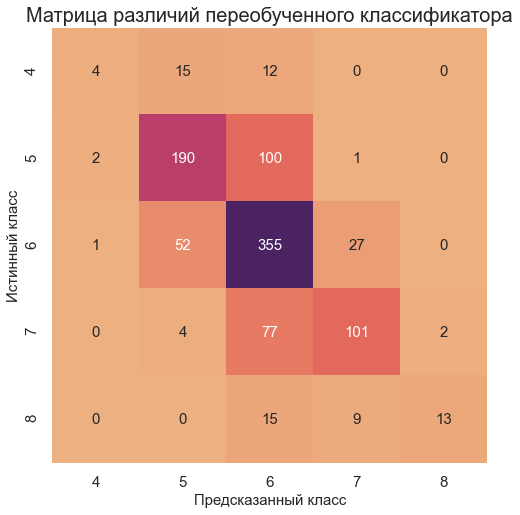

In [268]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, square=True, cbar=False, fmt='.0f', cmap='flare')
ax.set_title('Матрица различий переобученного классификатора', fontsize=BIG_SIZE)
ax.set_xticklabels([4, 5, 6, 7, 8], fontsize=SIZE)
ax.set_yticklabels([4, 5, 6, 7, 8], fontsize=SIZE)
ax.set_xlabel('Предсказанный класс', fontsize=SIZE)
ax.set_ylabel('Истинный класс', fontsize=SIZE)

Как видно из матрицы различий, переобученный классификатор склонен в каждом объекте видеть средний класс. Поэтому, по мере удаления от середины шкалы качества к краям, полнота неуклонно падает. В результате этого, 15 объектов 8 класса (вино лучшего качества) оказались в 6 классе (вино среднего качества) и 12 объектов 4 класса (вино худшего качества) тоже оказались в 6 классе.

In [84]:
# Чтобы избежать переобучения, определим для модели оптимальные параметры с помощью рандомизированного поиска
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=12)
parameters = {'max_depth': range(5, 20, 5), 
              'min_samples_leaf': range(9, 20), 'min_samples_split': range(10, 15),
              'max_leaf_nodes': range(300, 800, 100)}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) # количество блоков в стратифицированной перекрёстной проверке
rs = RandomizedSearchCV(clf, parameters, cv=kfold, n_iter=30, random_state=1, n_jobs=-1)
rs = rs.fit(X_train, y_train)

In [85]:
rs.best_params_ # лучшие параметры

{'min_samples_split': 11,
 'min_samples_leaf': 9,
 'max_leaf_nodes': 600,
 'max_depth': 15}

(array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

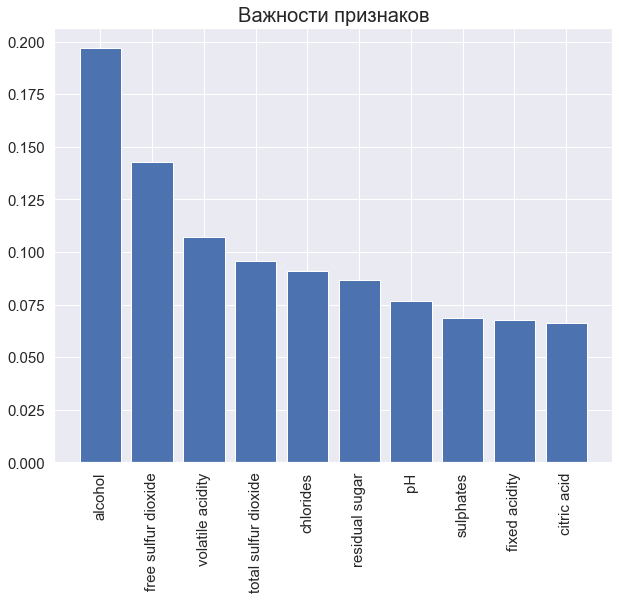

In [86]:
best_clf = rs.best_estimator_ # модель с лучшими параметрами
importances = best_clf.feature_importances_ # определение важности признаков
indices = np.argsort(importances)[::-1]
names = [list(X_train)[i] for i in indices]
plt.figure(figsize=(10, 8))
plt.title('Важности признаков', fontsize=BIG_SIZE)
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90, fontsize=SIZE)
plt.yticks(fontsize=SIZE)

Диаграмма важности признаков показывает, что самым важным признаком является alcohol (градусы), а наименее важным - citric acid (лимонная кислота). Также видно, что многократной разницы в важности признаков нет. Между самым важным и наименее важным признаками отличие около 3 раз, поэтому все признаки сохраняем. 

In [87]:
# предсказание модели с отрегулированными параметрами на тренировочной выборке
y_pred_train = best_clf.predict(X_train)
print(classification_report(y_train, y_pred_train, zero_division=0))

              precision    recall  f1-score   support

           4       0.53      0.98      0.69       152
           5       0.74      0.79      0.77      1164
           6       0.88      0.63      0.73      1763
           7       0.65      0.89      0.75       696
           8       0.71      1.00      0.83       143

    accuracy                           0.75      3918
   macro avg       0.70      0.86      0.75      3918
weighted avg       0.78      0.75      0.75      3918



Теперь классификатор не показывает наблюдаемый выше на тренировочной выборке идеальный результат, поэтому можно сделать вывод об отсутствии переобучения.

In [88]:
# предсказание модели с отрегулированными параметрами на тестовой выборке
y_pred_test = best_clf.predict(X_test)
print(classification_report(y_test, y_pred_test, zero_division=0))

              precision    recall  f1-score   support

           4       0.29      0.52      0.37        31
           5       0.61      0.63      0.62       293
           6       0.63      0.48      0.54       435
           7       0.49      0.66      0.56       184
           8       0.44      0.49      0.46        37

    accuracy                           0.56       980
   macro avg       0.49      0.56      0.51       980
weighted avg       0.58      0.56      0.56       980



В результате устранения переобучения модели, метрика recall принимает более равномерный набор значений, что свидетельствует о возросшей способности модели правильно классифицировать объекты 4 и 8 класса (полнота 0.52 и 0.49 соответственно). 

Text(50.760000000000005, 0.5, 'Истинный класс')

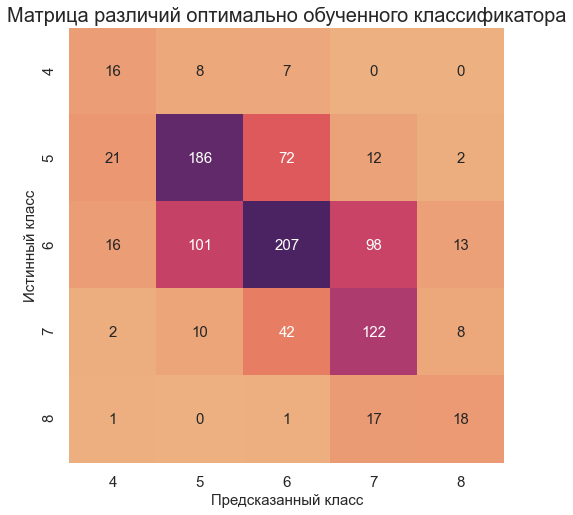

In [275]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, square=True, cbar=False, fmt='.0f', cmap='flare')
ax.set_title('Матрица различий оптимально обученного классификатора', fontsize=BIG_SIZE)
ax.set_xticklabels([4, 5, 6, 7, 8], fontsize=SIZE)
ax.set_yticklabels([4, 5, 6, 7, 8], fontsize=SIZE)
ax.set_xlabel('Предсказанный класс', fontsize=SIZE)
ax.set_ylabel('Истинный класс', fontsize=SIZE)

In [ ]:
Матрица различий подтверждает возросший recall для 4 и 8 классов(16 и 18 объектов соответственно распознаны правильно), и также 
видно, что 6 класс стал более однородным. Теперь в нём только 1 объект из 8 класса и 7 из 4 класса. Кроме того, объекты 
находящиеся на границах диапазонов признаков для 6 класса перешли в соседние классы, т.е. объекты на правой границе диапазона
перешли в вышестоящие классы (лучшие), а на левой границе - в нижестоящие(худшие). Таким образом, сбалансированно обученная модель
позволяет успешнее распознавать вина высокого и низкого качества (8 и 4 классы), а также сделать 6 класс (вино среднего 
качества) однороднее, по сравнению с переобученной моделью, стремившейся к максимальному расширению 6 класса . Расширился 4 класс 
(худшее качество) за счёт попадения в него самых низкосортных объектов из других классов и расширился 8 класс(высшее качество) 
из-за попадения в него объектов с наилучшим сочетанием признаков из других классов (кроме 4).